In [1]:
from IPython.display import display
from PIL import Image
import numpy as np
import torch
import math
import datetime

def show_tensor(data):
    img = data.clone()
    img = img.type(torch.uint8).numpy()[0][0]
    img = Image.fromarray(img, 'L')
    display(img)

class sTimer():
    def __init__(self, name):
        self.start = datetime.datetime.now()
        self.name = name

    def show(self, printer=True):
        ms = int((datetime.datetime.now() - self.start).total_seconds() * 1000)
        if printer:
            print("{}: {}ms".format(self.name, ms))
            
        return ms

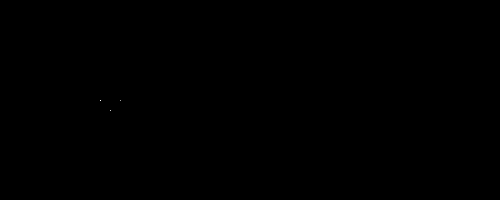

In [2]:
data = torch.zeros((1, 2, 200, 500), dtype=torch.float)

data[:, :, 100, 100] = 255
data[:, :, 110, 110] = 200
data[:, :, 100, 120] = 155
show_tensor(data)

In [3]:


def get_max_surrounding(data, kernel_size=3, only_under=True, smaller_sides=True):
    lines_skip = math.floor(kernel_size / 2)

    if only_under == True:
        out_channels = np.eye(kernel_size * kernel_size)[lines_skip*kernel_size:]
        if smaller_sides:
            for i in range(math.floor((kernel_size-1)/4)):
                out_channels[list(range(i, len(out_channels), kernel_size))] = False
                out_channels[list(range(kernel_size-i-1, len(out_channels), kernel_size))] = False
    else:
        out_channels = np.eye(kernel_size * kernel_size)
        
    w = out_channels.reshape((out_channels.shape[0], 1, kernel_size, kernel_size))
    w = torch.tensor(w, dtype=torch.float).cuda()
    
    data = data.transpose(0,1).cuda()
    
    patches = torch.nn.functional.conv2d(data, w, padding=(lines_skip, lines_skip))
    speed = torch.sqrt(torch.sum(torch.pow(patches, 2), axis=0))
    max_speeds = torch.argmax(speed, axis=0)
    flat_max_speeds = max_speeds.reshape(data.shape[2]*data.shape[3])
    print(max_speeds.shape, speed.shape, patches.shape)
    
    y_axis = torch.arange(data.shape[2]).repeat_interleave(data.shape[3])
    x_axis = torch.arange(data.shape[3]).repeat(data.shape[2])
    
    output = patches[:, flat_max_speeds, y_axis, x_axis]
    output = output.reshape(1, 2, data.shape[2], data.shape[3])
    return output

t = sTimer('Maxing')
new_data = get_max_surrounding(data, kernel_size=9)
new_data = get_max_surrounding(new_data, kernel_size=9)
new_data = get_max_surrounding(new_data, kernel_size=9)
new_data = get_max_surrounding(new_data, kernel_size=9)
t.show()

torch.Size([200, 500]) torch.Size([45, 200, 500]) torch.Size([2, 45, 200, 500])
torch.Size([200, 500]) torch.Size([45, 200, 500]) torch.Size([2, 45, 200, 500])
torch.Size([200, 500]) torch.Size([45, 200, 500]) torch.Size([2, 45, 200, 500])
torch.Size([200, 500]) torch.Size([45, 200, 500]) torch.Size([2, 45, 200, 500])
Maxing: 1154ms


1154

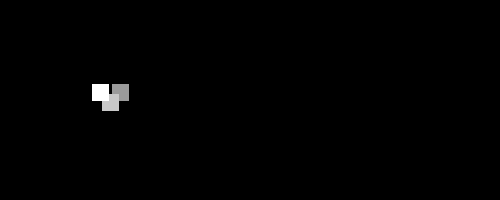

In [4]:
show_tensor(new_data.cpu())